# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 25 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 25 апреля, -4 баллов после 06:00 2 мая, -6 баллов после 06:00 9 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# %load_ext pycodestyle_magic


# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [2]:
# %%pycodestyle

class MyKmeans:

    def __init__(self, k=2, metric='euclidean',
                 max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        if self.metric == 'euclidean':
            self.distance = self.__distance_euk
        if self.metric == 'manhattan':
            self.distance = self.__distance_manh
        if self.metric == 'chebyshev':
            self.distance = self.__distance_cheb

    def __distance_euk(self, n, X):
        return np.sqrt(((X - self.centroids[n, :]) ** 2).sum(axis=1))

    def __distance_manh(self, n, X):
        return np.sum(np.abs(X - self.centroids[n, :]), axis=1)

    def __distance_cheb(self, n, X):
        return np.max(np.abs(X - self.centroids[n, :]), axis=1)

    def start_centroids(self, X):
        if self.init == 'random':
            self.centroids = X[np.random.choice(X.shape[0], self.k)]
        if self.init == 'k-means':
            self.centroids = np.empty((self.k, X.shape[1]))
            self.centroids[0, :] = X[np.random.randint(0, X.shape[0]), :]
            for i in range(1, self.k):
                dist = np.empty((self.k, X.shape[0]))
                for j in range(self.k):
                    dist[j, :] = self.distance(j, X)
                dist = np.min(dist, axis=0)
                dist = np.cumsum(dist / np.sum(dist))
                pos = np.random.sample()
                self.centroids[i, :] = X[dist[dist < pos].size, :]

    def calc_centroids(self, cl, X, labels):
        x = X[labels == cl, :]
        return np.sum(x, axis=0) / x.shape[0]

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        self.start_centroids(X)
        
        # Your Code Here
        centr = np.empty((self.k, X.shape[1]))
        for _ in range(self.max_iter):
            dist = np.empty((self.k, X.shape[0]))
            for i in range(self.k):
                dist[i, :] = self.distance(i, X)
            self.labels = np.argmin(dist, axis=0)
            for cl in range(self.k):
                centr[cl] = self.calc_centroids(cl, X, self.labels)
            if np.all(centr == self.centroids):
                break
            self.centroids = centr

        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера

        Возвращает метку ближайшего кластера для каждого объекта
        """
        dist = np.empty((self.k, X.shape[0]))
        for i in range(self.k):
            dist[i, :] = self.distance(i, X)
        return np.argmin(dist, axis=0)


class MiniBatchKMeans(MyKmeans):

    def __init__(self, k=2, metric='euclidean',
                 max_iter=1000, random_state=None, init='random',
                 batch_size=10):
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.init = init
        if self.metric == 'euclidean':
            self.distance = self.__distance_euk
        if self.metric == 'manhattan':
            self.distance = self.__distance_manh
        if self.metric == 'chebyshev':
            self.distance = self.__distance_cheb

    def __distance_euk(self, n, X):
        return np.sqrt(((X - self.centroids[n, :]) ** 2).sum(axis=1))

    def __distance_manh(self, n, X):
        return np.sum(np.abs(X - self.centroids[n, :]), axis=1)

    def __distance_cheb(self, n, X):
        return np.max(np.abs(X - self.centroids[n, :]), axis=1)

    def fit(self, X, y=None):
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        self.start_centroids(X)
        centr = np.empty((self.k, X.shape[1]))

        # Your Code Here
        for _ in range(self.max_iter):
            mask = np.random.choice(np.arange(X.shape[0]), self.batch_size)
            M = X[mask]
            dist = np.empty((self.k, M.shape[0]))
            for i in range(self.k):
                dist[i, :] = self.distance(i, M)
            self.labels[mask] = np.argmin(dist, axis=0)
            for cl in range(self.k):
                centr[cl] = self.calc_centroids(cl, M, self.labels[mask])
            if np.all(centr == self.centroids):
                break
            self.centroids = centr
        dist = np.empty((self.k, X.shape[0]))
        for i in range(self.k):
            dist[i, :] = self.distance(i, X)
        self.labels = np.argmin(dist, axis=0)

        return self
    

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [3]:
from sklearn.datasets import make_blobs


In [4]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)


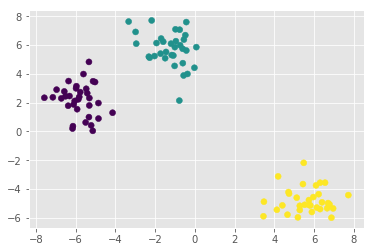

In [5]:
plt.scatter(X[:,0], X[:, 1], c=y)


Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

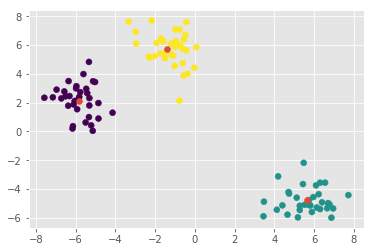

In [69]:
## Работоспособность MyKmeans
km = MyKmeans(k=3)
km.fit(X)
y_pred = km.predict(X)
plt.scatter(X[:,0], X[:, 1], c=y_pred)
plt.scatter(km.centroids[:, 0], km.centroids[:, 1])


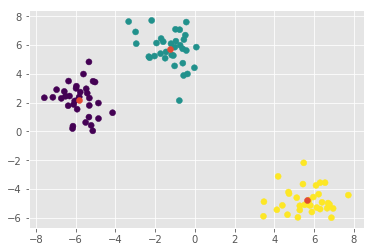

In [67]:
## Работоспособность MyKmeans++
km = MyKmeans(k=3, init='k-means')
km.fit(X)
y_pred = km.predict(X)
plt.scatter(X[:,0], X[:, 1], c=y_pred)
plt.scatter(km.centroids[:, 0], km.centroids[:, 1])


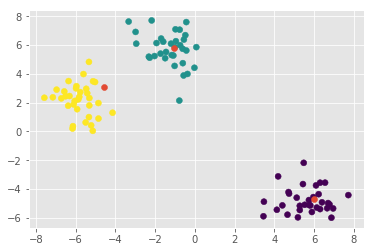

In [77]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
km = MiniBatchKMeans(k=3)
km.fit(X)
y_pred = km.predict(X)
plt.scatter(X[:,0], X[:, 1], c=y_pred)
plt.scatter(km.centroids[:, 0], km.centroids[:, 1])


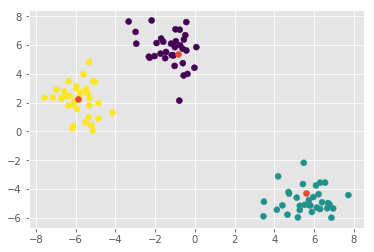

In [74]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
km = MiniBatchKMeans(k=3, init='k-means')
km.fit(X)
y_pred = km.predict(X)
plt.scatter(X[:,0], X[:, 1], c=y_pred)
plt.scatter(km.centroids[:, 0], km.centroids[:, 1])


Text(0,0.5,'time')

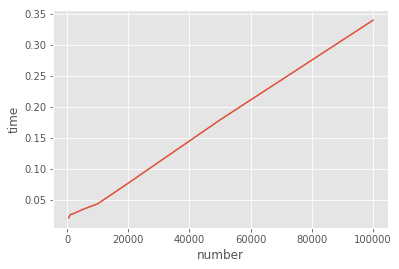

In [33]:
## Время выполнения алгоритма Kmeans из sklearn
import time
from sklearn.cluster import KMeans
sizes = [500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
t1 = np.empty(len(sizes))
for i, s in enumerate(sizes):
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=123)
    km = KMeans(n_clusters=3)
    tau = time.time()
    km.fit(X)
    t1[i] = time.time() - tau
plt.plot(sizes, t1)
plt.xlabel('number')
plt.ylabel('time')


Text(0,0.5,'time')

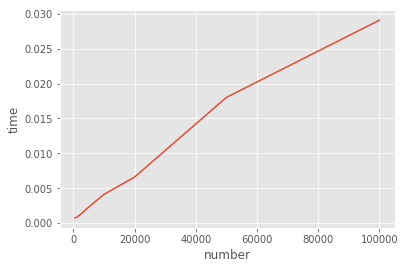

In [34]:
## Время выполнения алгоритма MyKmeans
t2 = np.empty(len(sizes))
for i, s in enumerate(sizes):
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=123)
    km = MyKmeans(k=3, max_iter=300)
    tau = time.time()
    km.fit(X)
    t2[i] = time.time() - tau
plt.plot(sizes, t2)
plt.xlabel('number')
plt.ylabel('time')


Text(0,0.5,'time')

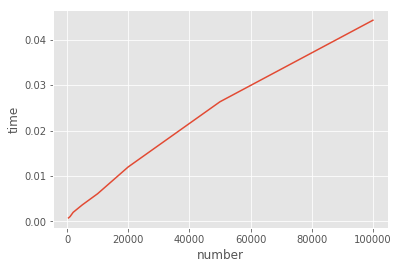

In [35]:
## Время выполнения алгоритма MyKmeans++
t3 = np.empty(len(sizes))
for i, s in enumerate(sizes):
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=123)
    km = MyKmeans(k=3, max_iter=300, init='k-means')
    tau = time.time()
    km.fit(X)
    t3[i] = time.time() - tau
plt.plot(sizes, t3)
plt.xlabel('number')
plt.ylabel('time')


Text(0,0.5,'time')

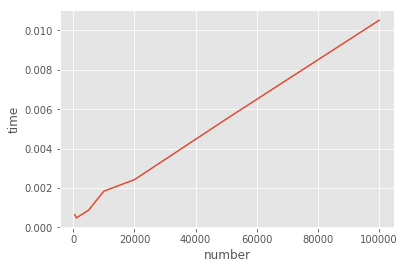

In [36]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
t4 = np.empty(len(sizes))
for i, s in enumerate(sizes):
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=123)
    km = MiniBatchKMeans(k=3, max_iter=300, batch_size=100)
    tau = time.time()
    km.fit(X)
    t4[i] = time.time() - tau
plt.plot(sizes, t4)
plt.xlabel('number')
plt.ylabel('time')


Text(0,0.5,'time')

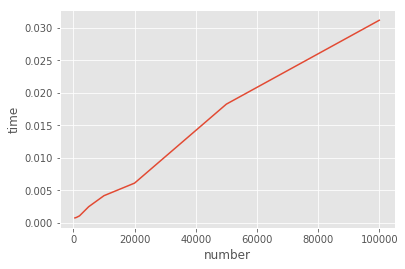

In [37]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
t5 = np.empty(len(sizes))
for i, s in enumerate(sizes):
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=123)
    km = MiniBatchKMeans(k=3, max_iter=300, init='k-means', batch_size=100)
    tau = time.time()
    km.fit(X)
    t5[i] = time.time() - tau
plt.plot(sizes, t5)
plt.xlabel('number')
plt.ylabel('time')


Text(0,0.5,'time')

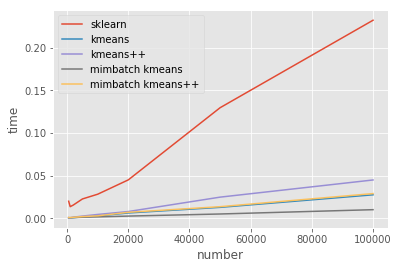

In [23]:
plt.plot(sizes, t1, label='sklearn')
plt.plot(sizes, t2, label='kmeans')
plt.plot(sizes, t3, label='kmeans++')
plt.plot(sizes, t4, label='mimbatch kmeans')
plt.plot(sizes, t5, label='mimbatch kmeans++')
plt.legend()
plt.xlabel('number')
plt.ylabel('time')


# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [3]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()


,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [4]:
df_sns = df_sns.drop(columns=['gradyear', 'gender', 'age', 'friends'])
df_sns


,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,2,0,0,0,0,0
7,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [5]:
X = df_sns.iloc[:, :].values
print(X)
X = X - X.mean(axis=0)
X = X / X.std(axis=0)
print(X)


[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 1 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]]
[[-0.33221726 -0.35769737 -0.2428741  ... -0.26153016 -0.22040264
  -0.1749076 ]
 [-0.33221726  1.06004883 -0.2428741  ... -0.26153016 -0.22040264
  -0.1749076 ]
 [-0.33221726  1.06004883 -0.2428741  ...  2.02790809 -0.22040264
  -0.1749076 ]
 ...
 [-0.33221726  1.06004883 -0.2428741  ... -0.26153016 -0.22040264
  -0.1749076 ]
 [-0.33221726 -0.35769737 -0.2428741  ... -0.26153016 -0.22040264
  -0.1749076 ]
 [ 2.15319868 -0.35769737 -0.2428741  ... -0.26153016 -0.22040264
  -0.1749076 ]]


In [6]:
k = 9
batch_size = 1000
words = df_sns.columns


In [10]:
from sklearn.cluster import KMeans


In [88]:
%%time
kmeans = KMeans(n_clusters=9, random_state=123).fit(X)

for i, centr in enumerate(kmeans.cluster_centers_):
    print(words[np.argsort(centr)[-5:]], km.labels[kmeans.labels_ == i].size)


Index(['dance', 'basketball', 'mall', 'cute', 'shopping'], dtype='object') 5036
Index(['die', 'sex', 'drugs', 'hair', 'drunk'], dtype='object') 1337
Index(['dress', 'rock', 'music', 'band', 'marching'], dtype='object') 752
Index(['basketball', 'shopping', 'football', 'sports', 'soccer'], dtype='object') 697
Index(['bible', 'death', 'jesus', 'tennis', 'blonde'], dtype='object') 20024
Index(['hair', 'death', 'drunk', 'sex', 'blonde'], dtype='object') 1
Index(['die', 'sex', 'hair', 'drugs', 'kissed'], dtype='object') 846
Index(['death', 'church', 'god', 'jesus', 'bible'], dtype='object') 466
Index(['clothes', 'mall', 'shopping', 'abercrombie', 'hollister'], dtype='object') 841
CPU times: user 4.76 s, sys: 104 ms, total: 4.86 s
Wall time: 2.44 s


In [84]:
%%time
## MyKMeans
km = MyKmeans(k=k)
km.fit(X)
for i, centr in enumerate(km.centroids):
    print(words[np.argsort(centr)[-5:]], km.labels[km.labels == i].size)


Index(['drunk', 'sex', 'hair', 'drugs', 'kissed'], dtype='object') 797
Index(['death', 'hair', 'die', 'god', 'clothes'], dtype='object') 521
Index(['basketball', 'volleyball', 'swimming', 'sports', 'softball'], dtype='object') 1697
Index(['rock', 'sports', 'basketball', 'football', 'baseball'], dtype='object') 241
Index(['music', 'death', 'god', 'church', 'jesus'], dtype='object') 1374
Index(['drunk', 'band', 'tennis', 'blonde', 'marching'], dtype='object') 20422
Index(['sexy', 'church', 'jesus', 'god', 'bible'], dtype='object') 441
Index(['football', 'shopping', 'basketball', 'sports', 'soccer'], dtype='object') 786
Index(['dress', 'mall', 'dance', 'shopping', 'cute'], dtype='object') 3721
CPU times: user 114 ms, sys: 18 µs, total: 114 ms
Wall time: 113 ms


In [11]:
%%time
## MyKMeans++
km = MyKmeans(k=k, init='k-means')
km.fit(X)
for i, centr in enumerate(km.centroids):
    print(words[np.argsort(centr)[-5:]], km.labels[km.labels == i].size)
    

Index(['clothes', 'shopping', 'softball', 'swimming', 'hot'], dtype='object') 2377
Index(['mall', 'shopping', 'dress', 'hollister', 'abercrombie'], dtype='object') 1354
Index(['mall', 'god', 'church', 'music', 'football'], dtype='object') 9056
Index(['football', 'baseball', 'rock', 'basketball', 'sports'], dtype='object') 731
Index(['marching', 'bible', 'sexy', 'blonde', 'drunk'], dtype='object') 12349
Index(['kissed', 'clothes', 'hair', 'hollister', 'abercrombie'], dtype='object') 90
Index(['shopping', 'music', 'cute', 'clothes', 'tennis'], dtype='object') 1325
Index(['sex', 'kissed', 'death', 'die', 'dance'], dtype='object') 1484
Index(['drunk', 'death', 'sex', 'drugs', 'hair'], dtype='object') 1234
CPU times: user 387 ms, sys: 4.25 ms, total: 391 ms
Wall time: 389 ms


In [86]:
%%time
## MyKMeans с MiniBatchMyKMeans
km = MiniBatchKMeans(k=k, batch_size=batch_size)
km.fit(X)
for i, centr in enumerate(km.centroids):
    print(words[np.argsort(centr)[-5:]], km.labels[km.labels == i].size)
    

Index(['basketball', 'god', 'football', 'sports', 'sexy'], dtype='object') 1895
Index(['dress', 'shopping', 'drunk', 'rock', 'dance'], dtype='object') 1425
Index(['hollister', 'mall', 'hair', 'dress', 'cute'], dtype='object') 3442
Index(['sex', 'die', 'marching', 'band', 'cheerleading'], dtype='object') 1314
Index(['death', 'football', 'basketball', 'volleyball', 'softball'], dtype='object') 236
Index(['bible', 'jesus', 'god', 'church', 'music'], dtype='object') 3527
Index(['bible', 'marching', 'drunk', 'blonde', 'baseball'], dtype='object') 17026
Index(['mall', 'cute', 'hair', 'kissed', 'clothes'], dtype='object') 510
Index(['basketball', 'shopping', 'volleyball', 'soccer', 'tennis'], dtype='object') 625
CPU times: user 62.3 ms, sys: 19 µs, total: 62.3 ms
Wall time: 60.8 ms


In [24]:
%%time
## MyKMeans++ с MiniBatchMyKMeans
km = MiniBatchKMeans(k=k, batch_size=batch_size, init='k-means')
km.fit(X)
for i, centr in enumerate(km.centroids):
    print(words[np.argsort(centr)[-5:]], km.labels[km.labels == i].size)
    

/home/mary/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: overflow encountered in square


Index(['shopping', 'football', 'hollister', 'volleyball', 'cheerleading'], dtype='object') 843
Index(['church', 'sports', 'bible', 'god', 'jesus'], dtype='object') 96
Index(['baseball', 'hollister', 'basketball', 'abercrombie', 'football'], dtype='object') 2242
Index(['drugs', 'blonde', 'dance', 'sexy', 'soccer'], dtype='object') 21643
Index(['die', 'cute', 'shopping', 'dress', 'death'], dtype='object') 2650
Index(['cute', 'mall', 'shopping', 'hair', 'clothes'], dtype='object') 836
Index(['sex', 'die', 'clothes', 'hair', 'kissed'], dtype='object') 54
Index(['god', 'hair', 'church', 'band', 'marching'], dtype='object') 802
Index(['sex', 'drugs', 'hair', 'drunk', 'kissed'], dtype='object') 834
CPU times: user 366 ms, sys: 4.06 ms, total: 370 ms
Wall time: 366 ms


In [ ]:
## Вывод
# Кластеры на разных моделях получились примерно похожие. 
# Что касается центров - то, пожалуй, единственый метод,
# в котором не возникло вопросов почему эти слова вместе - k-means++ с MiniBatch.
# Больше всего у меня возникло вопросов 
# (конкретно 2) в kmeans++. К тому же k-means++ (и k-means с MiniBatch) 
# заметно проигрывает по скорости обычному, 
# поскольку долго делается начальное приближение. 
# MiniBatch k-means работает по скорости лучше, чем обычный k-means почти в 2 раза, 
# что сильно будет сказываться на больших данных.

# Вывод: k-means и k-means с MiniBatch одинаковы по точности (если судить по центроидам), 
# но k-means с MiniBatch выигрывает по времени. Откуда вывод, 
# что k-means с MiniBatch - самый оптимальный вариант.
